# Multi-view 2D dataset generation

In [7]:
from data.synthetic_dataset import multiview_moon

random_state = 42
n_training_samples = 1000
n_test_grid=200
num_views = 2

train_X, train_Y, test_X, ood_X = multiview_moon(
    radius_list=[1.7,1.0,0.3], 
    n_training_samples=n_training_samples, 
    n_test_grid=n_test_grid, 
    n_ood_samples=200, 
    random_state=random_state)

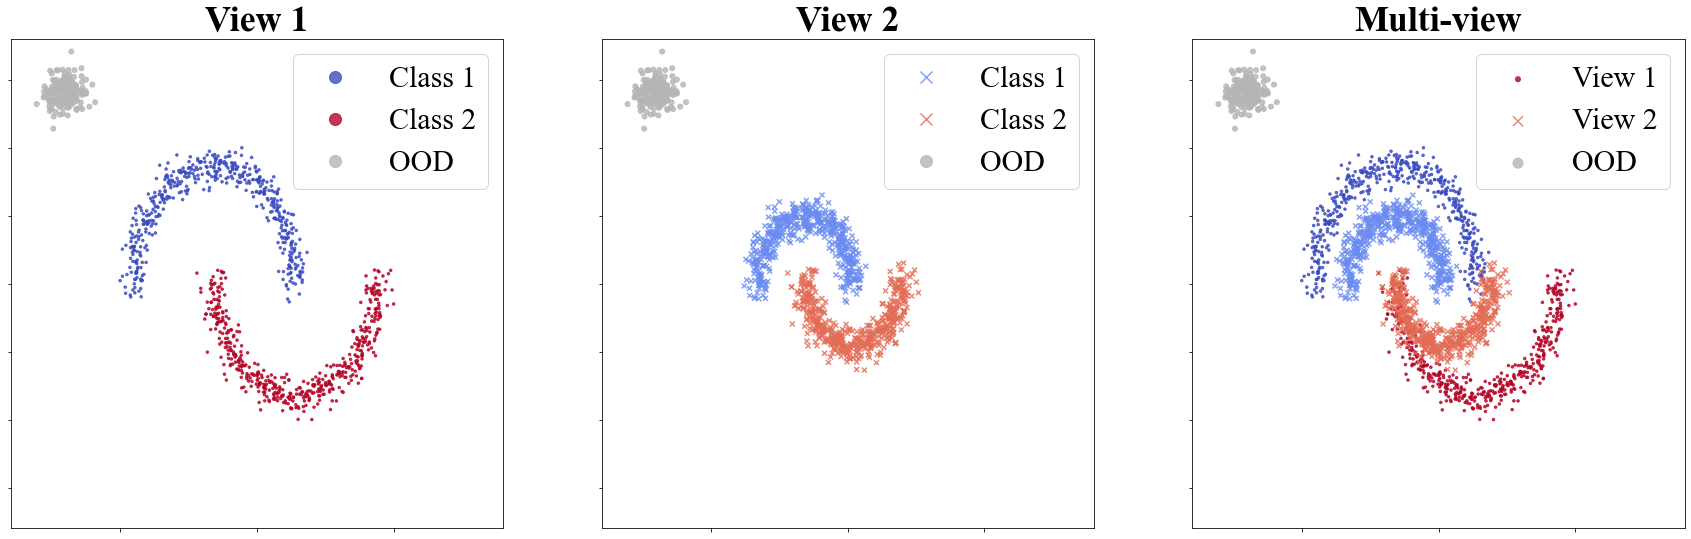

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import NullFormatter
import matplotlib

# Dataset parameters
alpha = 0.8
markersize = 25
markerscale = 2.0
plt.rcParams['font.size'] = 30
plt.rcParams["font.family"] = "Times New Roman"

# Colormaps used
grey=matplotlib.colors.ListedColormap(plt.get_cmap('Greys')(np.linspace(0.4,1.0,2)))
cmap1=matplotlib.colors.ListedColormap(plt.get_cmap('coolwarm')(np.linspace(0.,1.0,2)))
cmap2=matplotlib.colors.ListedColormap(plt.get_cmap('coolwarm')(np.linspace(0.15,0.85,2)))


# Visualize dataset
fig = plt.figure(figsize=(10*3, 9))

ax = plt.subplot(1,3,1)
scatter1=ax.scatter(train_X[:n_training_samples,0],train_X[:n_training_samples,1],c=train_Y, marker='.', alpha=alpha, s=markersize, cmap=cmap1)
scatter2=ax.scatter(ood_X[0],ood_X[1], marker='o', alpha=alpha, s=markersize, c=np.ones(len(ood_X[1])), cmap=grey)
ax.set_xlim(test_X[:,0].min(),test_X[:,0].max())
ax.set_ylim(test_X[:,1].min(),test_X[:,1].max())
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
ax.legend(handles=scatter1.legend_elements()[0]+scatter2.legend_elements()[0],labels=['Class 1','Class 2','OOD'],markerscale=markerscale)
plt.title('View 1', fontweight ='bold')

ax = plt.subplot(1,3,2)
scatter1=ax.scatter(train_X[n_training_samples:n_training_samples*2,0],train_X[n_training_samples:n_training_samples*2,1],c=train_Y, marker='x', alpha=alpha, s=markersize, cmap=cmap2)
scatter2=ax.scatter(ood_X[0],ood_X[1], marker='o', alpha=alpha, s=markersize, c=np.ones(len(ood_X[1])), cmap=grey)
ax.set_xlim(test_X[:,0].min(),test_X[:,0].max())
ax.set_ylim(test_X[:,1].min(),test_X[:,1].max())
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
ax.legend(handles=scatter1.legend_elements()[0]+scatter2.legend_elements()[0],labels=['Class 1','Class 2','OOD'],markerscale=markerscale)
plt.title('View 2', fontweight ='bold')

ax = plt.subplot(1,3,3)
ax.scatter(train_X[:n_training_samples,0],train_X[:n_training_samples,1],c=train_Y, marker='.', alpha=alpha, s=markersize, cmap=cmap1)
ax.scatter(train_X[n_training_samples:n_training_samples*2,0],train_X[n_training_samples:n_training_samples*2,1],c=train_Y, marker='x', alpha=alpha, s=markersize, cmap=cmap2)
ax.scatter(ood_X[0],ood_X[1], marker='o', alpha=alpha, s=markersize, c=np.ones(len(ood_X[1])), cmap=grey)
ax.set_xlim(test_X[:,0].min(),test_X[:,0].max())
ax.set_ylim(test_X[:,1].min(),test_X[:,1].max())
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
ax.legend(['View 1','View 2','OOD'], markerscale=markerscale)
plt.title('Multi-view', fontweight ='bold')

plt.show()

# Create training set and testing set

In [9]:
import tensorflow as tf

batch_size = 200
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_X[:n_training_samples],train_X[n_training_samples:2*n_training_samples],train_Y)).shuffle(
        n_training_samples, seed=random_state).repeat().batch(batch_size)
train_size = n_training_samples
test_dataset = [test_X, test_X]

# Train the model

In [10]:
from sklearn.metrics import accuracy_score
from models.MGP import MGP
from tqdm import tqdm

def train(lr, train_dataset, a_eps, weighting, num_inducing_points, epochs=100, multi_optimizers=True):
    

    num_classes = 2    
    resnet_layers = 6
    resnet_hidden = 128
    dims = [resnet_hidden for _ in range(num_views)]
    steps_per_epoch = train_size // batch_size

    model = MGP(
            num_classes, 
            num_inducing_points, 
            num_experts=len(dims), 
            x_dims=dims, 
            a_eps=a_eps,
            resnet_layers=resnet_layers,
            resnet_hidden=resnet_hidden)
    single_batch_sample = next(iter(train_dataset.unbatch().batch(num_inducing_points).take(1)))[:num_views]
    model.initialize(single_batch_sample, train_size)
    if multi_optimizers:
        optimizer_feat = tf.keras.optimizers.Adam(learning_rate=3e-4)
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    else:
        lr_scheduler = tf.keras.optimizers.schedules.PolynomialDecay(1e-2, 10*steps_per_epoch, 3e-3)
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)

    def train_step(inputs, epoch):
        (*X, label) = inputs

        with tf.GradientTape() as tape:
            gp_vars = [tuple(model.experts[i].trainable_variables) for i in range(num_views)]
            gp_variables = sum(gp_vars,())
            num_vars_experts = len(gp_variables)
            feat_vars = [tuple(model.feat_extractors[i].trainable_variables) for i in range(num_views)]
            train_variables = gp_variables + sum(feat_vars,())
            tape.watch(train_variables)

            _, _, p_combined, _, loss = model(X, label, weighting, training=True)

    
        gradients = tape.gradient(loss, train_variables)
        if multi_optimizers:
            optimizer.apply_gradients(zip(gradients[:num_vars_experts], train_variables[:num_vars_experts]))
            optimizer_feat.apply_gradients(zip(gradients[num_vars_experts:], train_variables[num_vars_experts:]))
        elif epoch < 10:
            optimizer.apply_gradients(zip(gradients[:num_vars_experts], train_variables[:num_vars_experts]))
        else:
            optimizer.apply_gradients(zip(gradients, train_variables))

        return accuracy_score(label, tf.math.argmax(p_combined, axis=1))

    train_iterator = iter(train_dataset)
    for epoch in range(epochs):
        with tqdm(total=steps_per_epoch, desc='Train Epoch #{}'.format(epoch+1)) as t:
            for step in range(steps_per_epoch):
                train_comb_acc = train_step(next(train_iterator),epoch)
                t.set_postfix({'Training acc': train_comb_acc})

                t.update(1)

    return model


In [11]:
# MGP works better with separate optimizers for feature extractor and MGP
# but it works with single optimizer as well
multi_optimizers=True

epochs = 30
lr = 8e-3
model = train(lr, train_dataset, 1e-3, 'entropy', 200, epochs, multi_optimizers)
mgp_p_experts, var_experts, mgp_p_combined, var_combined, loss = model(test_dataset, np.zeros(test_dataset[0].shape[0]), 'entropy', training=False)
mgp_uncertainty_experts = [tf.reduce_sum(var_experts[i], axis=1) for i in range(num_views)]
mgp_uncertainty_combined = tf.reduce_sum(var_combined, axis=1)

Train Epoch #30: 100%|██████████| 5/5 [00:00<00:00,  6.60it/s, Training acc=0.995]


# Visualize test results

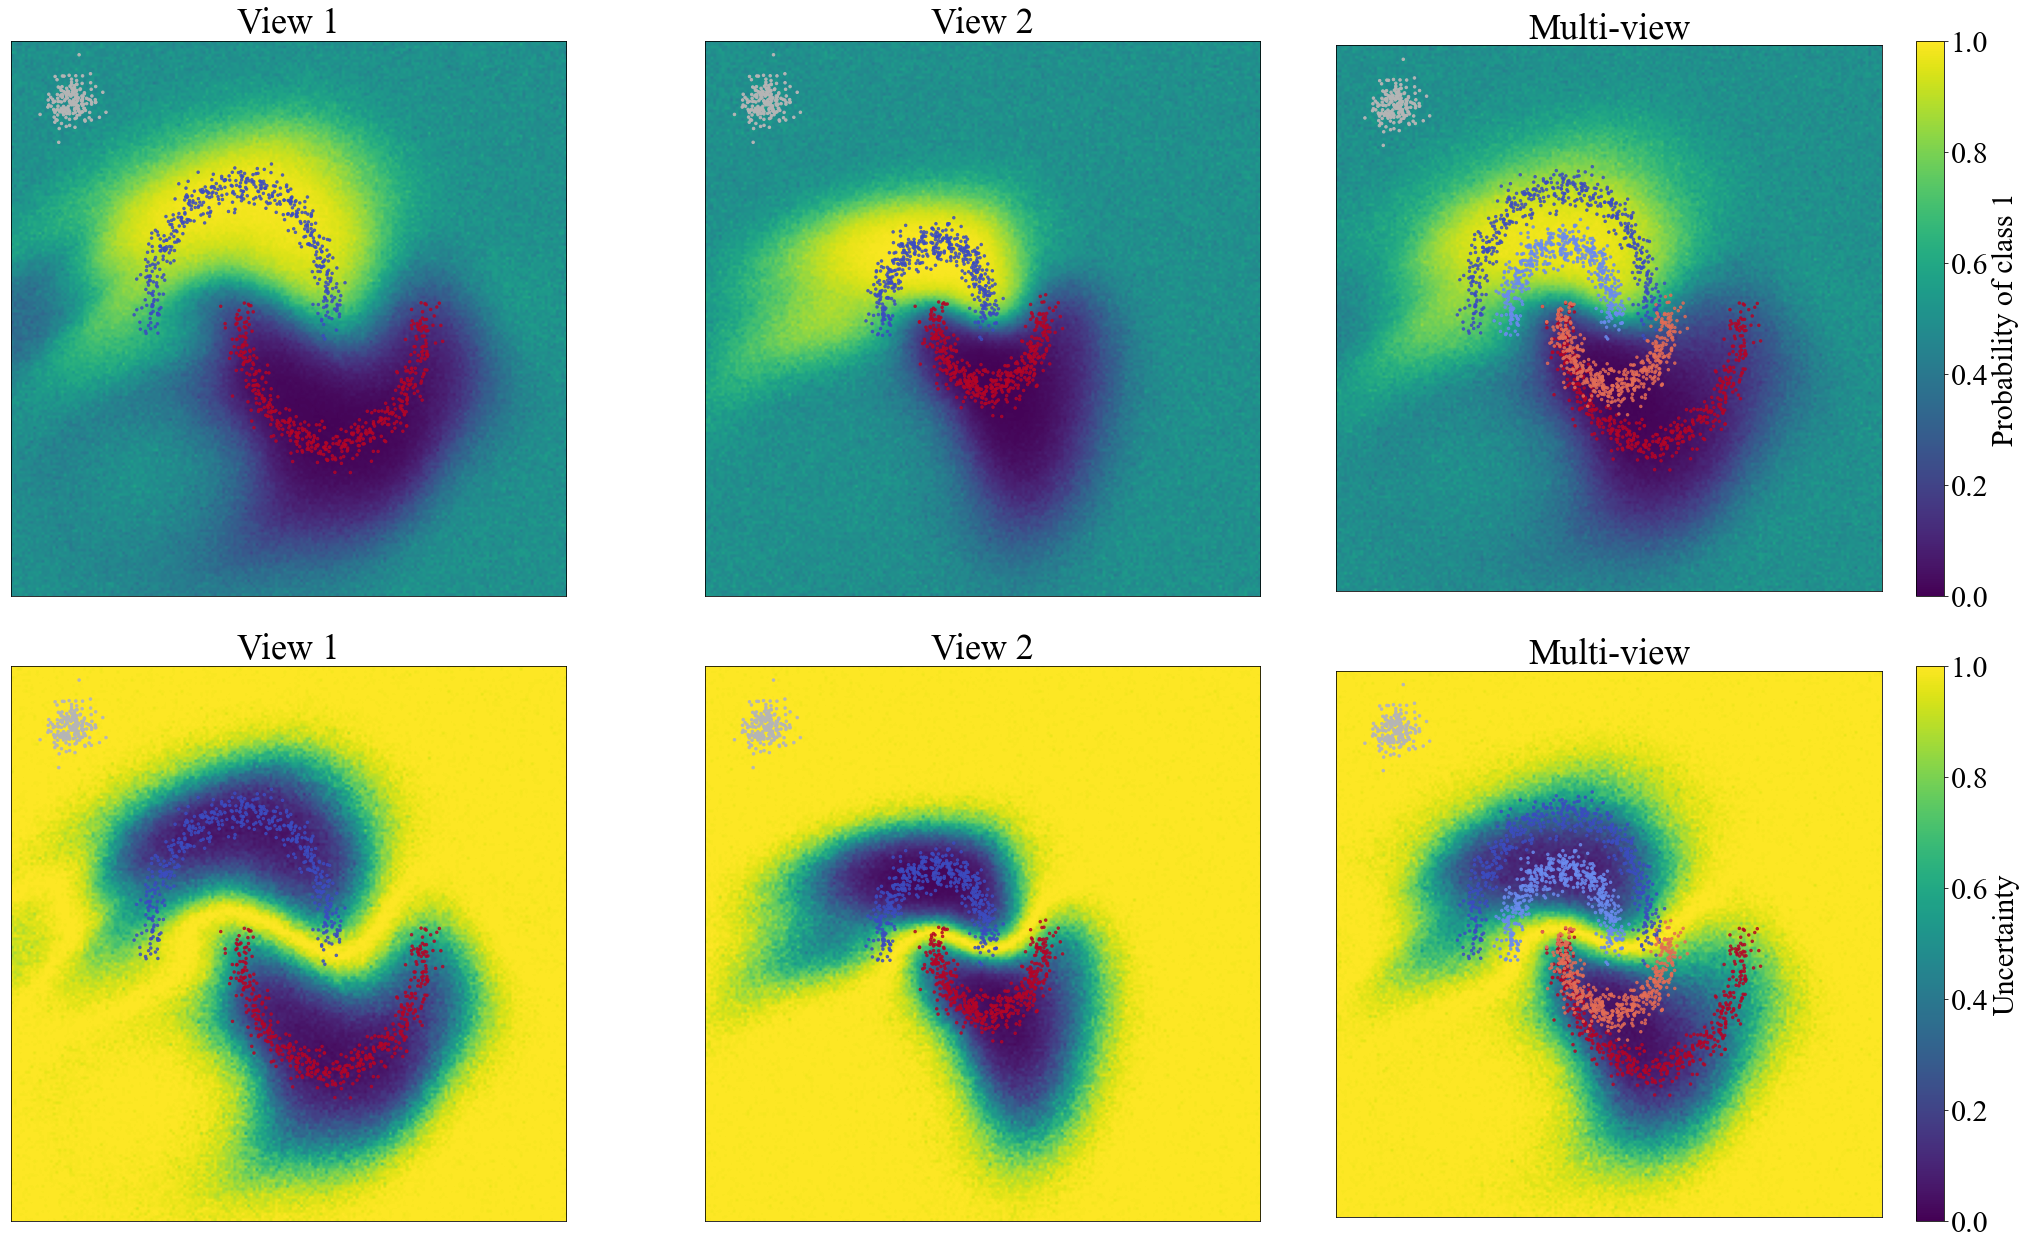

In [12]:
fig = plt.figure(figsize=(10*3, 18))


for view in range(1,3):
    ax = plt.subplot(2,3,view)
    ax.imshow(np.transpose(np.reshape(mgp_p_experts[view-1][:,0],(n_test_grid,n_test_grid))),origin="lower",vmin=0,vmax=1,extent=(np.min(test_X[:,0]),np.max(test_X[:,0]),np.min(test_X[:,1]),np.max(test_X[:,1])))
    ax.scatter(train_X[n_training_samples*(view-1):n_training_samples*view,0],train_X[n_training_samples*(view-1):n_training_samples*view,1],c=train_Y, marker='.', s=markersize, alpha=alpha, cmap=cmap1)
    ax.scatter(ood_X[0],ood_X[1], marker='.', s=markersize, c=np.ones(len(ood_X[1])), cmap=grey)

    ax.set_xlim(test_X[:,0].min(),test_X[:,0].max())
    ax.set_ylim(test_X[:,1].min(),test_X[:,1].max())
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_title(f'View {view}')

ax = plt.subplot(2,3,3)
prob_plt = ax.imshow(np.transpose(np.reshape(mgp_p_combined[:,0],(n_test_grid,n_test_grid))),origin="lower",vmin=0,vmax=1,extent=(np.min(test_X[:,0]),np.max(test_X[:,0]),np.min(test_X[:,1]),np.max(test_X[:,1])))
ax.scatter(train_X[:n_training_samples,0],train_X[:n_training_samples,1],c=train_Y, marker='.', s=markersize, alpha=alpha, cmap=cmap1)
ax.scatter(train_X[n_training_samples:n_training_samples*2,0],train_X[n_training_samples:n_training_samples*2,1],c=train_Y, marker='.', s=markersize, alpha=alpha, cmap=cmap2)
ax.scatter(ood_X[0],ood_X[1], marker='.', s=markersize, c=np.ones(len(ood_X[1])), cmap=grey)

ax.set_xlim(test_X[:,0].min(),test_X[:,0].max())
ax.set_ylim(test_X[:,1].min(),test_X[:,1].max())
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_title('Multi-view')
cb = plt.colorbar(prob_plt, ax=ax)
cb.set_label('Probability of class 1')

for view in range(1,3):
    ax = plt.subplot(2,3,view+3)
    ax.imshow(np.transpose(np.reshape(mgp_uncertainty_experts[view-1]/0.5,(n_test_grid,n_test_grid))),origin="lower",vmin=0,vmax=1,extent=(np.min(test_X[:,0]),np.max(test_X[:,0]),np.min(test_X[:,1]),np.max(test_X[:,1])))
    ax.scatter(train_X[n_training_samples*(view-1):n_training_samples*view,0],train_X[n_training_samples*(view-1):n_training_samples*view,1],c=train_Y, marker='.', s=markersize, alpha=alpha, cmap=cmap1)
    ax.scatter(ood_X[0],ood_X[1], marker='.', s=markersize, c=np.ones(len(ood_X[1])), cmap=grey)

    ax.set_xlim(test_X[:,0].min(),test_X[:,0].max())
    ax.set_ylim(test_X[:,1].min(),test_X[:,1].max())

    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_title(f'View {view}')

ax = plt.subplot(2,3,6)
prob_plt = ax.imshow(np.transpose(np.reshape(mgp_uncertainty_combined/0.5,(n_test_grid,n_test_grid))),origin="lower",vmin=0,vmax=1,extent=(np.min(test_X[:,0]),np.max(test_X[:,0]),np.min(test_X[:,1]),np.max(test_X[:,1])))
ax.scatter(train_X[:n_training_samples,0],train_X[:n_training_samples,1],c=train_Y, marker='.', s=markersize, alpha=alpha, cmap=cmap1)
ax.scatter(train_X[n_training_samples:n_training_samples*2,0],train_X[n_training_samples:n_training_samples*2,1],c=train_Y, marker='.', s=markersize, alpha=alpha, cmap=cmap2)
ax.scatter(ood_X[0],ood_X[1], marker='.', s=markersize, c=np.ones(len(ood_X[1])), cmap=grey)

ax.set_xlim(test_X[:,0].min(),test_X[:,0].max())
ax.set_ylim(test_X[:,1].min(),test_X[:,1].max())
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_title('Multi-view')
cb = plt.colorbar(prob_plt, ax=ax)
cb.set_label('Uncertainty')

plt.tight_layout()

plt.show()
